In [42]:
from processing_functions import *
from itertools import product
from tabulate import tabulate
%matplotlib inline

In [43]:
# reading datasets
personal_data = pd.read_csv('./dataset/Ovarian/ovar_data_mar22_d032222.csv')
screen_data = pd.read_csv('./dataset/Ovarian/Screening/ovar_screen_data_mar22_d032222.csv')
screen_abnorm_data = pd.read_csv('./dataset/Ovarian/Screening Abnormalities/ovar_scrsub_data_mar22_d032222.csv')

In [44]:
def print_records_vs_unique(df, col, dataset_name, print_vals=True):
    # Get unique IDs
    if print_vals:
        print(f"Num of records in {dataset_name} dataset: {len(df)}")
        print(f"Num of unique {col} in {dataset_name} dataset: {len(df[col].unique())}")
    return len(df), len(df[col].unique())

def print_df(df):
    print(tabulate(df, headers='keys', tablefmt='psql'))

def print_records_vs_unique_for(df, col, dataset_name, on):
    print_records_vs_unique(df, col, dataset_name)
    # Look at unique IDs for each of the years of study for screen dataset
    for val in sorted(df[on].unique()):
        # Get unique IDs
        print_records_vs_unique(df[df[on] == val], col, f'{dataset_name}.{on}={val}')

def get_missing_values_cols(df):
    percent_missing = df.isnull().sum() * 100 / len(df)
    missing_value_df = pd.DataFrame({'column_name': df.columns,
                                    'num_missing': df.isnull().sum(),
                                    'num_present': len(df) - df.isnull().sum(),
                                    'percent_missing': percent_missing})
    missing_value_df.sort_values('percent_missing', inplace=True)
    # missing_value_df = missing_value_df[missing_value_df.percent_missing != 0]
    return missing_value_df

def get_unique_combinations(lists):
    return set(product(*lists))

def get_cols_missing_percentage(cutoff_percentage, df, name, show_missing=True):
    df_missing_value = get_missing_values_cols(df)
    df_missing_value.to_csv(f'./feature_selection/missing_percentage_{name}.csv', index=False)
    df_missing_value = df_missing_value[df_missing_value.percent_missing >= cutoff_percentage]
    print(f'{len(df_missing_value)} columns were over {cutoff_percentage} missing. This is the list of columns: {df_missing_value["column_name"].to_list()}')
    print('The list of features and percentage missing: ')
    if show_missing:
        print_df(df_missing_value)
    return df_missing_value

def drop_cols_missing_percentage(cutoff_percentage, df, name, show_missing=True):
    print(f'Removing features that are over {cutoff_percentage}% missing')
    df_missing_value = get_cols_missing_percentage(cutoff_percentage, df, name, show_missing=show_missing)
    return df.drop(df_missing_value['column_name'].to_list(), axis=1)
    
def remove_featues_startswith(df, prefixes, exclude=[]):
    for prefix in prefixes:
        remove_cols = []
        for col in df.columns:
            if col.startswith(prefix):
                remove_cols.append(col)
        print(f'Number of {prefix} cols: {len(remove_cols)}')
        print(remove_cols)
        remove_cols = list(set(remove_cols) - set(exclude))
        df = df.drop(remove_cols, axis=1)
    return df

def merge_df_into_features(sourse_df, on_col, make_unique_over_cols, join='outer'):
    unique_vals_list = [sorted(sourse_df[make_unique_over_col].unique()) for make_unique_over_col in make_unique_over_cols]
    unique_combinations_col_vals = get_unique_combinations(unique_vals_list)
    merged_df = None
    for unique_combination in unique_combinations_col_vals:
        filter = True
        col_suffix = ''
        for i in range(len(make_unique_over_cols)):
            variable_col = make_unique_over_cols[i]
            val = unique_combination[i]
            col_suffix += f'_{variable_col}_{val}'
            filter = filter & (sourse_df[variable_col] == val)
        df = sourse_df[filter]
        # Drop cols which we use to create unique features
        # df = df.drop(make_unique_over_cols, axis=1)
        # Create new col names
        cols = df.columns
        cols_dict = {}
        for col in cols:
            if col not in [on_col]:
                cols_dict[col] = f'{col}_{col_suffix}'
        df = df.rename(columns=cols_dict)
        # Get unique IDs
        if merged_df is None:
            merged_df = df
        else:
            merged_df = merged_df.merge(df, on=on_col, how=join)
    return merged_df

## Preprocessing
For some of the datasets we determined some of the features to not be useful for analysis. For every dataset that includes `build` features. 

For personal dataset we removed all `ovar_` features since they are a direct result of the cancer diagnosis and should not be used predict cancer. 

For the screen data dataset it was determined that `examinerid_` features do not bring the value to the dataset since they represet 'Examiner ID made by concatentating center and exam ID for overall screen result.' and cannot be the cause of the cancer. We also drop all of the remaining

In [45]:
# Drop build feature
personal_data = personal_data.drop(['build'], axis=1)
# Remove all ovar_ features
personal_data = remove_featues_startswith(personal_data, ['ovar_'], ['ovar_cancer_diagdays', 'ovar_cancer', 'ovar_exitdays'])

# Remove all inad_ and examinerid_ and build_ features
screen_data = remove_featues_startswith(screen_data, ['inad_', 'examinerid', 'build'])

# Drop not useful cols and convert categorical into numerical in screen abnormalities
screen_abnorm_data = screen_abnorm_data.drop('build', axis=1)

Number of ovar_ cols: 50
['ovar_reasfoll', 'ovar_reassurv', 'ovar_reassymp', 'ovar_reasoth', 'ovar_cancer', 'ovar_intstat_cat', 'ovar_annyr', 'ovar_cancer_site', 'ovar_stage', 'ovar_stage_7e', 'ovar_stage_t', 'ovar_stage_n', 'ovar_stage_m', 'ovar_clinstage', 'ovar_clinstage_7e', 'ovar_clinstage_t', 'ovar_clinstage_n', 'ovar_clinstage_m', 'ovar_pathstage', 'ovar_pathstage_7e', 'ovar_pathstage_t', 'ovar_pathstage_n', 'ovar_pathstage_m', 'ovar_grade', 'ovar_topography', 'ovar_morphology', 'ovar_behavior', 'ovar_histtype', 'ovar_exitstat', 'ovar_exitage', 'ovar_seer', 'ovar_cancer_first', 'ovar_curative_surg', 'ovar_curative_chemo', 'ovar_primary_trt', 'ovar_num_heslide_imgs', 'ovar_has_deliv_heslide_img', 'ovar_exitdays', 'ovar_primary_trt_days', 'ovar_cancer_diagdays', 'ovar_mra_stat0', 'ovar_mra_stat1', 'ovar_mra_stat2', 'ovar_mra_stat3', 'ovar_mra_stat4', 'ovar_mra_stat5', 'ovar_eligible_bq', 'ovar_eligible_sqx', 'ovar_eligible_dhq', 'ovar_eligible_dqx']
Number of inad_ cols: 42
['inad

In [46]:
print_records_vs_unique(personal_data, 'plco_id', 'personal')
# Check the number of people with cancer
personal_data_cancer = personal_data[personal_data['ovar_cancer']==1]
print(f"Num of patients with cancer: {len(personal_data_cancer)}")
# Check the number of people without cancer
personal_data_no_cancer = personal_data[personal_data['ovar_cancer']==0]
print(f"Num of patients without cancer: {len(personal_data_no_cancer)}")

Num of records in personal dataset: 78209
Num of unique plco_id in personal dataset: 78209
Num of patients with cancer: 613
Num of patients without cancer: 77596


# TODO: should `inad_` features to be used to disqualify exam result? 
# TODO: should we drop features that are 95% missing and above? Some of the features seem to be exclusive 

## `TODO:` Determining which feature to use for determining when the patient got cancer

In [47]:
personal_data_cancer[['plco_id', 'ovar_cancer_diagdays', 'fstcan_exitdays', 'ovar_exitdays']].describe().T

,count,mean,std,min,25%,50%,75%,max
ovar_cancer_diagdays,613.0,2751.973899,1751.601513,5.0,1213.0,2745.0,4137.0,6895.0
fstcan_exitdays,613.0,2512.432300,1596.348029,5.0,1068.0,2564.0,3826.0,5800.0
ovar_exitdays,613.0,2647.187602,1606.080617,5.0,1213.0,2745.0,3929.0,5804.0


In [48]:
len(personal_data_cancer[personal_data_cancer['ovar_cancer_diagdays']<5*365])

221

- '`ovar_cancer_diagdays`' - Ovarian Confirmed Cancer Diagnosis Days
- '`fstcan_exitdays`' - Days from trial entry (randomization) to first cancer diagnosis for participants with cancer, or to trial exit otherwise. Only cancers occuring during the trial are used to determine exit.
- '`ovar_exitdays`' - Days from trial entry (randomization) to cancer diagnosis for participants with ovarian, peritoneal, or fallopian tube cancer, or to trial exit otherwise.

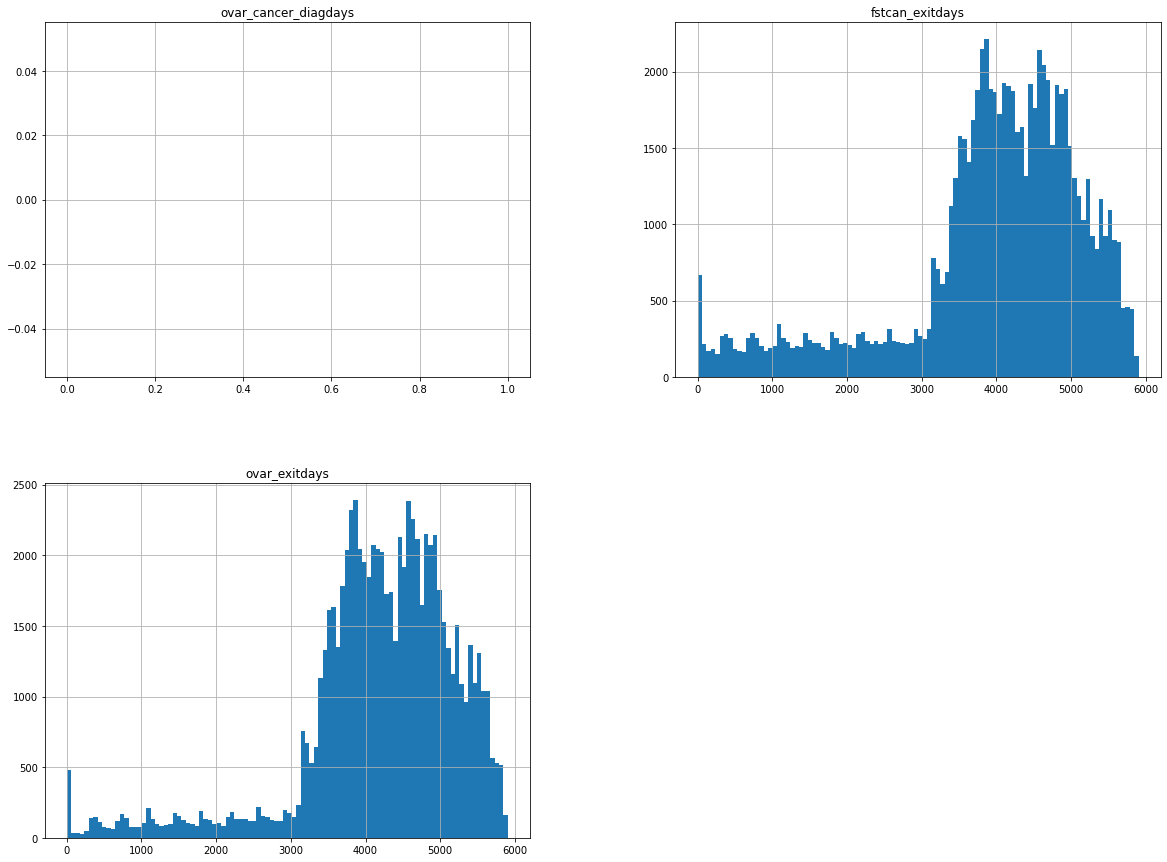

In [49]:
personal_data_no_cancer[['plco_id', 'ovar_cancer_diagdays', 'fstcan_exitdays', 'ovar_exitdays']].hist(figsize=(20,15), bins=100);

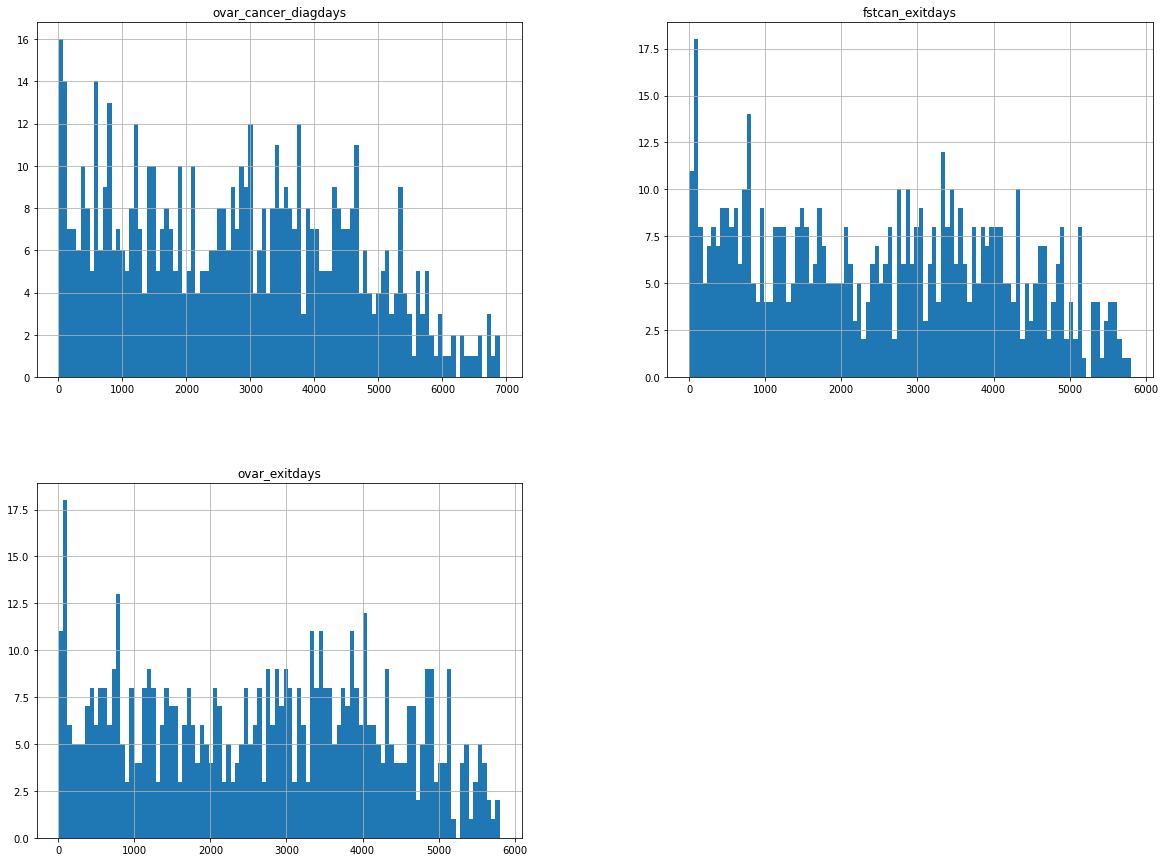

In [50]:
personal_data_cancer[['plco_id', 'ovar_cancer_diagdays', 'fstcan_exitdays', 'ovar_exitdays']].hist(figsize=(20,15), bins=100);

## Missing Values Analysis
`['study_yr', 'side', 'source', 'VISIT', 'sbcd']`

In [51]:
def df_missing_val_distribution_over_col(df, on_col, cutoff_percentage, title):
    iterate_over_on_col = sorted(df[on_col].unique())
    suffixes=[]
    for on_col_val in iterate_over_on_col:
        suffixes.append(f'_{on_col}_{on_col_val}')
    df_missing = None
    for on_col_val in iterate_over_on_col:

        df_on_col = df[df[on_col] == on_col_val]

        num_records, num_unique = print_records_vs_unique(df_on_col, 'plco_id', f'{title} with {on_col}_{on_col_val}')
        df_missing_on_col = get_cols_missing_percentage(cutoff_percentage, df_on_col, f'{title} with {on_col}_{on_col_val}')
        
        if df_missing is not None:
            df_missing = df_missing.merge(df_missing_on_col, on='column_name', how='inner', suffixes=suffixes)
        else:
            df_missing = df_missing_on_col
    print_df(df_missing)


def df_filter_val_distribution(sourse_df, on_col, make_unique_over_cols, name, hist=True, cutoff_percentage=0, join='outer', suffixes=['_cancer', '_no_cancer']):
    unique_vals_list = [sorted(sourse_df[make_unique_over_col].unique()) for make_unique_over_col in make_unique_over_cols]
    unique_combinations_col_vals = get_unique_combinations(unique_vals_list)
    merged_df = None
    num_records, num_unique = print_records_vs_unique(sourse_df, 'plco_id', name)
    unique_combinations_col_vals = sorted(unique_combinations_col_vals)
    unique_records = [{} for _ in range(len(unique_combinations_col_vals)+1)]
    unique_records[0] = {
            'filtered_on': f'{name} total'
        }
    
    iterate_over_on_col = sorted(sourse_df[on_col].unique())
    suffixes=[]
    for on_col_val in iterate_over_on_col:
        num_records, num_unique = print_records_vs_unique(sourse_df[sourse_df[on_col] == on_col_val], 'plco_id', f'{name} with {on_col}_{on_col_val}')
        unique_records[0][f'num_records_{on_col}:{on_col_val}'] = num_records
        unique_records[0][f'num_unique_id_{on_col}:{on_col_val}'] = num_unique
        suffixes.append(f'_{on_col}_{on_col_val}')
    print()
    print()
    for j in range(len(unique_combinations_col_vals)):
        unique_combination = unique_combinations_col_vals[j]
        filter = True
        filtered_on = ''
        for i in range(len(make_unique_over_cols)):
            variable_col = make_unique_over_cols[i]
            val = unique_combination[i]
            filter = filter & (sourse_df[variable_col] == val)
            filtered_on += f'{variable_col}: {val} '
        df = sourse_df[filter]
        if len(make_unique_over_cols) > 0:
            df = df.drop(make_unique_over_cols, axis=1)

        title = f'{name} filtered on {filtered_on}'
        print(title)

        df_missing = None
        unique_records[j+1]['filtered_on'] = title
        for on_col_val in iterate_over_on_col:

            df_on_col = df[df[on_col] == on_col_val]

            num_records, num_unique = print_records_vs_unique(df_on_col, 'plco_id', f'{title} with {on_col}_{on_col_val}')
            df_missing_on_col = get_cols_missing_percentage(cutoff_percentage, df_on_col, f'{title} with {on_col}_{on_col_val}')
            
            if df_missing is not None:
                df_missing = df_missing.merge(df_missing_on_col, on='column_name', how='inner', suffixes=suffixes)
            else:
                df_missing = df_missing_on_col
            unique_records[j+1][f'num_records_{on_col}:{on_col_val}'] = num_records
            unique_records[j+1][f'num_unique_id_{on_col}:{on_col_val}'] = num_unique
        print_df(df_missing)
        df = impute_with_val(df, df.columns, -1)
        for on_col_val in df[on_col].unique():
            if hist:
                fig, ax = plt.subplots(1, 1, figsize=(20,15))
                df.hist(ax=ax, bins=30)
                plt.show()
        print('\n\n')
    print_df(pd.DataFrame(unique_records).sort_values('filtered_on'))

def df_filter_val_distribution_on_cancer(source_df, make_unique_over_cols, name, hist=False, cutoff_percentage=0):
    df_cancer = source_df[source_df['plco_id'].isin(personal_data_cancer['plco_id'])]
    df_cancer['cancer'] = 1
    df_no_cancer = source_df[source_df['plco_id'].isin(personal_data_no_cancer['plco_id'])]
    df_no_cancer['cancer'] = 0
    df = pd.concat([df_cancer, df_no_cancer], axis=0)
    df_filter_val_distribution(df, 'cancer', make_unique_over_cols, name, hist=hist, cutoff_percentage=cutoff_percentage)

In [52]:
print(personal_data.columns.to_list())

['ovar_cancer', 'plco_id', 'build_cancers', 'build_incidence_cutoff', 'ovar_exitdays', 'ovar_cancer_diagdays', 'biopolink0', 'biopolink1', 'biopolink2', 'biopolink3', 'biopolink4', 'biopolink5', 'tvu_result0', 'tvu_result1', 'tvu_result2', 'tvu_result3', 'ca125_result0', 'ca125_result1', 'ca125_result2', 'ca125_result3', 'ca125_result4', 'ca125_result5', 'ca125_level0', 'ca125_level1', 'ca125_level2', 'ca125_level3', 'ca125_level4', 'ca125_level5', 'ca125_src0', 'ca125_src1', 'ca125_src2', 'ca125_src3', 'ca125_src4', 'ca125_src5', 'ca125ii_level0', 'ca125ii_level1', 'ca125ii_level2', 'ca125ii_level3', 'ca125ii_level4', 'ca125ii_level5', 'orem_fyro', 'ca125_prot', 'ovary_trial_flag', 'ca125_days0', 'ca125_days1', 'ca125_days2', 'ca125_days3', 'ca125_days4', 'ca125_days5', 'tvu_days0', 'tvu_days1', 'tvu_days2', 'tvu_days3', 'educat', 'marital', 'occupat', 'pipe', 'cigar', 'sisters', 'brothers', 'asp', 'ibup', 'fmenstr', 'menstrs', 'miscar', 'tubal', 'tuballig', 'bbd', 'benign_ovcyst', 'e

In [53]:
make_unique_over_cols = ['dummy']
df = personal_data
df['dummy'] = 0
df_filter_val_distribution_on_cancer(df, make_unique_over_cols, 'Personal Data', hist=False, cutoff_percentage=0)

Num of records in Personal Data dataset: 78209


C:\Users\fedor\AppData\Local\Temp\ipykernel_111804\1504729185.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cancer['cancer'] = 1
C:\Users\fedor\AppData\Local\Temp\ipykernel_111804\1504729185.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_cancer['cancer'] = 0


Num of unique plco_id in Personal Data dataset: 78209
Num of records in Personal Data with cancer_0 dataset: 77596
Num of unique plco_id in Personal Data with cancer_0 dataset: 77596
Num of records in Personal Data with cancer_1 dataset: 613
Num of unique plco_id in Personal Data with cancer_1 dataset: 613


Personal Data filtered on dummy: 0 
Num of records in Personal Data filtered on dummy: 0  with cancer_0 dataset: 77596
Num of unique plco_id in Personal Data filtered on dummy: 0  with cancer_0 dataset: 77596
195 columns were over 0 missing. This is the list of columns: ['ovar_cancer', 'bq_returned', 'race7', 'd_dthovar', 'f_dthovar', 'is_dead_with_cod', 'is_dead', 'mortality_exitage', 'mortality_exitstat', 'build_death_cutoff', 'mortality_exitdays', 'ph_any_trial', 'in_TGWAS_population', 'ph_ovar_trial', 'rndyear', 'arm', 'sex', 'age', 'agelevel', 'dual', 'reconsent_outcome', 'reconsent_outcome_days', 'fstcan_exitstat', 'fstcan_exitage', 'fstcan_exitdays', 'center', 'ovary_trial_f

In [54]:
make_unique_over_cols = ['study_yr']
df_filter_val_distribution_on_cancer(screen_data, make_unique_over_cols, 'Screen Data', hist=False, cutoff_percentage=0)

Num of records in Screen Data dataset: 150993
Num of unique plco_id in Screen Data dataset: 30849


C:\Users\fedor\AppData\Local\Temp\ipykernel_111804\1504729185.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cancer['cancer'] = 1
C:\Users\fedor\AppData\Local\Temp\ipykernel_111804\1504729185.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_cancer['cancer'] = 0


Num of records in Screen Data with cancer_0 dataset: 149793
Num of unique plco_id in Screen Data with cancer_0 dataset: 30552
Num of records in Screen Data with cancer_1 dataset: 1200
Num of unique plco_id in Screen Data with cancer_1 dataset: 297


Screen Data filtered on study_yr: 0 
Num of records in Screen Data filtered on study_yr: 0  with cancer_0 dataset: 28638
Num of unique plco_id in Screen Data filtered on study_yr: 0  with cancer_0 dataset: 28638
79 columns were over 0 missing. This is the list of columns: ['cancer', 'ovar_result', 'ovcyst_morphr', 'ovcyst_morphl', 'ovcyst_morph', 'ovcyst_sumr', 'ovcyst_suml', 'ovcyst_sum', 'visl', 'visr', 'visboth', 'viseith', 'numcystl', 'numcystr', 'numcyst', 'plco_id', 'ca125_result', 'tvu_result', 'ovar_days', 'ca125_days', 'ca125_level', 'ca125ii_src', 'ca125_src', 'tvu_days', 'phycons', 'tvu_ref', 'medcomp', 'detr_p', 'detl_p', 'tvures_pvis1', 'tvudays_pvis1', 'ca125ii_assess_days', 'ovcyst_vol', 'ovcyst_diam', 'ovary_diam', 'ovary_vo

In [55]:
df_missing_value = get_cols_missing_percentage(0, personal_data, 'personal_data')
df_missing_value[df_missing_value['column_name'].isin(['ovar_cancer_diagdays', 'fstcan_exitdays', 'ovar_exitdays'])]

195 columns were over 0 missing. This is the list of columns: ['ovar_cancer', 'bq_returned', 'race7', 'd_dthovar', 'f_dthovar', 'is_dead_with_cod', 'is_dead', 'mortality_exitage', 'mortality_exitstat', 'build_death_cutoff', 'mortality_exitdays', 'ph_any_trial', 'in_TGWAS_population', 'ph_ovar_trial', 'rndyear', 'arm', 'sex', 'age', 'agelevel', 'dual', 'reconsent_outcome', 'reconsent_outcome_days', 'fstcan_exitstat', 'fstcan_exitage', 'fstcan_exitdays', 'center', 'ovary_trial_flag', 'dummy', 'biopolink3', 'plco_id', 'build_cancers', 'build_incidence_cutoff', 'ovar_exitdays', 'biopolink0', 'biopolink1', 'biopolink2', 'biopolink4', 'biopolink5', 'bq_compdays', 'entryage_bq', 'ph_any_bq', 'ph_ovar_bq', 'entrydays_bq', 'post_menopausal', 'menstrs_stat_type', 'bq_age', 'smoked_f', 'cig_stat', 'preg_f', 'ovariesr_f', 'ca125_history', 'usound_history', 'pelvic_history', 'cigpd_f', 'hyster_f', 'livec', 'horm_stat', 'horm_f', 'mammo_history', 'bcontr_f', 'marital', 'papsmear_history', 'pregc', '

,column_name,num_missing,num_present,percent_missing
fstcan_exitdays,fstcan_exitdays,0,78209,0.000000
ovar_exitdays,ovar_exitdays,0,78209,0.000000
ovar_cancer_diagdays,ovar_cancer_diagdays,77596,613,99.216203


In [56]:
get_cols_missing_percentage(95, screen_data, 'screen_data')

24 columns were over 95 missing. This is the list of columns: ['ovcyst_solidr', 'tvu_assess_days_q', 'detl_q', 'detr_q', 'tvures_qvis1', 'QAMETHOD', 'ovcyst_outliner', 'ca125i_assess_days', 'ovcyst_solidl', 'ovcyst_outlinel', 'rantero_q', 'rvol_q', 'rtran_q', 'rlong_q', 'ltran_q', 'llong_q', 'lantero_q', 'lvol_q', 'tvudays_pvis2', 'tvures_pvis2', 'tvures_qvis2', 'tvures_pvis3', 'tvudays_pvis3', 'tvures_qvis3']
The list of features and percentage missing: 
+--------------------+--------------------+---------------+---------------+-------------------+
|                    | column_name        |   num_missing |   num_present |   percent_missing |
|--------------------+--------------------+---------------+---------------+-------------------|
| ovcyst_solidr      | ovcyst_solidr      |        143469 |          7524 |           95.017  |
| tvu_assess_days_q  | tvu_assess_days_q  |        143530 |          7463 |           95.0574 |
| detl_q             | detl_q             |        143541 | 

,column_name,num_missing,num_present,percent_missing
ovcyst_solidr,ovcyst_solidr,143469,7524,95.016988
tvu_assess_days_q,tvu_assess_days_q,143530,7463,95.057387
detl_q,detl_q,143541,7452,95.064672
detr_q,detr_q,143542,7451,95.065334
tvures_qvis1,tvures_qvis1,143576,7417,95.087852
QAMETHOD,QAMETHOD,143688,7305,95.162027
ovcyst_outliner,ovcyst_outliner,143754,7239,95.205738
ca125i_assess_days,ca125i_assess_days,143844,7149,95.265343
ovcyst_solidl,ovcyst_solidl,143924,7069,95.318326
ovcyst_outlinel,ovcyst_outlinel,144177,6816,95.485883


In [57]:
print_records_vs_unique_for(screen_data, 'plco_id', 'screen', 'study_yr')

Num of records in screen dataset: 150993
Num of unique plco_id in screen dataset: 30849
Num of records in screen.study_yr=0 dataset: 28919
Num of unique plco_id in screen.study_yr=0 dataset: 28919
Num of records in screen.study_yr=1 dataset: 27607
Num of unique plco_id in screen.study_yr=1 dataset: 27607
Num of records in screen.study_yr=2 dataset: 26637
Num of unique plco_id in screen.study_yr=2 dataset: 26637
Num of records in screen.study_yr=3 dataset: 25459
Num of unique plco_id in screen.study_yr=3 dataset: 25459
Num of records in screen.study_yr=4 dataset: 20146
Num of unique plco_id in screen.study_yr=4 dataset: 20146
Num of records in screen.study_yr=5 dataset: 22225
Num of unique plco_id in screen.study_yr=5 dataset: 22225


The question is how should we merge the duplicate records per participant id since for each set of features `['study_yr', 'side', 'source', 'VISIT', 'sbcd']` a participant might have records with different values for the rest of the columns. If we treat the rest of the features as unique based on the combination of these: `['study_yr', 'side', 'source', 'VISIT', 'sbcd']`, we would produce a massive number of missing features since there are 144 combinations of these `['study_yr', 'side', 'source', 'VISIT', 'sbcd']` features. So, assuming 100% presence of data, it would mean that after converting all the data into features using that method would result in there being at most 1 record per 144 rows of data. But in reality it results in 840 columns with no data whatsoever. This is an issue. The question is how to merge that data into featues. 

## `TODO:`
- for `VISIT` we can take an average for a year
- for `sbcd` (Subrecord Number) we can take an average for a year. Not sure what is the difference between different subrecords
- for `source` (Source of Report (TVU/TVQ)) - not sure how to deal with this one
- for `study_yr` and `side` I propose creating unique features over the combination of these values (10 combinations total 5 years and 2 sides [L, R])

The plots below plot the distribution of values over the particular value of some feature e.g. `source` or `study_yr`

In [58]:
make_unique_over_cols = ['source']
df_filter_val_distribution_on_cancer(screen_abnorm_data, make_unique_over_cols, 'Screen Abnormalities', hist=False, cutoff_percentage=0)

Num of records in Screen Abnormalities dataset: 20186
Num of unique plco_id in Screen Abnormalities dataset: 6992
Num of records in Screen Abnormalities with cancer_0 dataset: 19860
Num of unique plco_id in Screen Abnormalities with cancer_0 dataset: 6881
Num of records in Screen Abnormalities with cancer_1 dataset: 326
Num of unique plco_id in Screen Abnormalities with cancer_1 dataset: 111


Screen Abnormalities filtered on source: TVQ 
Num of records in Screen Abnormalities filtered on source: TVQ  with cancer_0 dataset: 1703
Num of unique plco_id in Screen Abnormalities filtered on source: TVQ  with cancer_0 dataset: 1097
15 columns were over 0 missing. This is the list of columns: ['VISIT', 'side', 'sbcd', 'study_yr', 'solid', 'plco_id', 'build_cancers', 'build_incidence_cutoff', 'cancer', 'echo', 'maxdi', 'volum', 'sepst', 'cyst', 'cystw']
The list of features and percentage missing: 
+------------------------+------------------------+---------------+---------------+-------------

C:\Users\fedor\AppData\Local\Temp\ipykernel_111804\1504729185.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cancer['cancer'] = 1
C:\Users\fedor\AppData\Local\Temp\ipykernel_111804\1504729185.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_cancer['cancer'] = 0


In [59]:
make_unique_over_cols = ['side']
df_filter_val_distribution_on_cancer(screen_abnorm_data, make_unique_over_cols, 'Screen Abnormalities', hist=False, cutoff_percentage=0)

Num of records in Screen Abnormalities dataset: 20186
Num of unique plco_id in Screen Abnormalities dataset: 6992
Num of records in Screen Abnormalities with cancer_0 dataset: 19860
Num of unique plco_id in Screen Abnormalities with cancer_0 dataset: 6881
Num of records in Screen Abnormalities with cancer_1 dataset: 326
Num of unique plco_id in Screen Abnormalities with cancer_1 dataset: 111


Screen Abnormalities filtered on side: L 
Num of records in Screen Abnormalities filtered on side: L  with cancer_0 dataset: 9520
Num of unique plco_id in Screen Abnormalities filtered on side: L  with cancer_0 dataset: 4011
15 columns were over 0 missing. This is the list of columns: ['VISIT', 'sbcd', 'study_yr', 'source', 'plco_id', 'build_cancers', 'build_incidence_cutoff', 'cancer', 'solid', 'echo', 'maxdi', 'volum', 'sepst', 'cyst', 'cystw']
The list of features and percentage missing: 
+------------------------+------------------------+---------------+---------------+-------------------+
| 

C:\Users\fedor\AppData\Local\Temp\ipykernel_111804\1504729185.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cancer['cancer'] = 1
C:\Users\fedor\AppData\Local\Temp\ipykernel_111804\1504729185.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_cancer['cancer'] = 0


In [60]:
screen_abnorm_data = screen_abnorm_data.replace({'L': 0, 'R': 1, 'TVU': 0, 'TVQ': 1})
make_unique_over_cols = ['study_yr']
df_filter_val_distribution_on_cancer(screen_abnorm_data, make_unique_over_cols, 'Screen Abnormalities', hist=False, cutoff_percentage=0)

C:\Users\fedor\AppData\Local\Temp\ipykernel_111804\1504729185.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cancer['cancer'] = 1


Num of records in Screen Abnormalities dataset: 20186
Num of unique plco_id in Screen Abnormalities dataset: 6992
Num of records in Screen Abnormalities with cancer_0 dataset: 19860
Num of unique plco_id in Screen Abnormalities with cancer_0 dataset: 6881
Num of records in Screen Abnormalities with cancer_1 dataset: 326
Num of unique plco_id in Screen Abnormalities with cancer_1 dataset: 111


Screen Abnormalities filtered on study_yr: 0 
Num of records in Screen Abnormalities filtered on study_yr: 0  with cancer_0 dataset: 5296
Num of unique plco_id in Screen Abnormalities filtered on study_yr: 0  with cancer_0 dataset: 3478
15 columns were over 0 missing. This is the list of columns: ['VISIT', 'side', 'sbcd', 'source', 'plco_id', 'build_cancers', 'build_incidence_cutoff', 'cancer', 'echo', 'maxdi', 'solid', 'cyst', 'sepst', 'cystw', 'volum']
The list of features and percentage missing: 
+------------------------+------------------------+---------------+---------------+---------------

C:\Users\fedor\AppData\Local\Temp\ipykernel_111804\1504729185.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_cancer['cancer'] = 0


## Merging data into features and mean imputing


## `TODO:` should we mean impute before and after or just after? Also, should we use labeled imputation?

In [61]:
# Mean impute before converting into features
screen_data = mean_impute(screen_data, select_numeric_columns(screen_data))
# Turn screen dataset each year into a feature
merged_data_screen = merge_df_into_features(screen_data, 'plco_id', ['study_yr'])
print_records_vs_unique(merged_data_screen, 'plco_id', 'merged_data_screen')
# Mean impute after converting into features
merged_data_screen = mean_impute(merged_data_screen, select_numeric_columns(merged_data_screen))

# Drop features that are 100% missing
merged_data_screen = drop_cols_missing_percentage(100, merged_data_screen, 'merged_data_screen')

Num of records in merged_data_screen dataset: 30849
Num of unique plco_id in merged_data_screen dataset: 30849
Removing features that are over 100% missing
6 columns were over 100 missing. This is the list of columns: ['tvures_qvis3__study_yr_0', 'tvures_qvis3__study_yr_1', 'tvures_qvis3__study_yr_2', 'tvures_qvis3__study_yr_4', 'tvures_qvis3__study_yr_3', 'tvures_qvis3__study_yr_5']
The list of features and percentage missing: 
+--------------------------+--------------------------+---------------+---------------+-------------------+
|                          | column_name              |   num_missing |   num_present |   percent_missing |
|--------------------------+--------------------------+---------------+---------------+-------------------|
| tvures_qvis3__study_yr_0 | tvures_qvis3__study_yr_0 |         30849 |             0 |               100 |
| tvures_qvis3__study_yr_1 | tvures_qvis3__study_yr_1 |         30849 |             0 |               100 |
| tvures_qvis3__study_yr_2 

In [62]:
print_records_vs_unique_for(screen_abnorm_data, 'plco_id', 'screen_abnorm_data', 'study_yr')

Num of records in screen_abnorm_data dataset: 20186
Num of unique plco_id in screen_abnorm_data dataset: 6992
Num of records in screen_abnorm_data.study_yr=0 dataset: 5418
Num of unique plco_id in screen_abnorm_data.study_yr=0 dataset: 3546
Num of records in screen_abnorm_data.study_yr=1 dataset: 5029
Num of unique plco_id in screen_abnorm_data.study_yr=1 dataset: 3305
Num of records in screen_abnorm_data.study_yr=2 dataset: 4902
Num of unique plco_id in screen_abnorm_data.study_yr=2 dataset: 3117
Num of records in screen_abnorm_data.study_yr=3 dataset: 4837
Num of unique plco_id in screen_abnorm_data.study_yr=3 dataset: 2959


In [63]:
# Mean Impute before converting into new features
screen_abnorm_data = mean_impute(screen_abnorm_data, select_numeric_columns(screen_abnorm_data))
# Turn screen dataset each year into a feature
make_unique_over_cols = ['study_yr', 'side', 'source', 'VISIT', 'sbcd']
merged_data_screen_abd = merge_df_into_features(screen_abnorm_data, 'plco_id', make_unique_over_cols)
print_records_vs_unique(merged_data_screen_abd, 'plco_id', 'screen_abnorm_data')
# Mean Impute before converting into new features
merged_data_screen_abd = mean_impute(merged_data_screen_abd, select_numeric_columns(merged_data_screen_abd))

# Drop features that are 100% missing
merged_data_screen_abd = drop_cols_missing_percentage(100, merged_data_screen_abd, 'merged_data_screen_abd')

# Convert Categorical features
merged_data_screen_abd = merged_data_screen_abd.replace({'L': 0, 'R': 1, 'TVU': 0, 'TVQ': 1})

Num of records in screen_abnorm_data dataset: 6992
Num of unique plco_id in screen_abnorm_data dataset: 6992
Removing features that are over 100% missing
840 columns were over 100 missing. This is the list of columns: ['cyst__study_yr_1_side_1_source_1_VISIT_2_sbcd_3', 'cyst__study_yr_2_side_0_source_0_VISIT_2_sbcd_3', 'cystw__study_yr_2_side_0_source_0_VISIT_2_sbcd_3', 'echo__study_yr_2_side_0_source_0_VISIT_2_sbcd_3', 'maxdi__study_yr_2_side_0_source_0_VISIT_2_sbcd_3', 'cystw__study_yr_1_side_1_source_1_VISIT_3_sbcd_2', 'volum__study_yr_2_side_0_source_0_VISIT_2_sbcd_3', 'build_cancers__study_yr_2_side_0_source_0_VISIT_2_sbcd_3', 'cyst__study_yr_1_side_1_source_1_VISIT_3_sbcd_2', 'study_yr__study_yr_1_side_1_source_1_VISIT_2_sbcd_3', 'sepst__study_yr_2_side_0_source_0_VISIT_2_sbcd_3', 'sepst__study_yr_1_side_1_source_1_VISIT_3_sbcd_2', 'solid__study_yr_1_side_1_source_1_VISIT_3_sbcd_2', 'source__study_yr_1_side_1_source_1_VISIT_3_sbcd_2', 'study_yr__study_yr_1_side_1_source_1_VISIT_3

In [64]:
# Drop profy features
proxy_features = [
    # 'ph_ovar_muq', # Did the participant have a personal history of ovarian/ft/pt cancer prior to MUQ analysis entry?
    'ovar_cancer_diagdays', 
    'fstcan_exitdays', 
    'ovar_exitdays'
    ]
personal_data_cancer = personal_data_cancer.drop(proxy_features, axis=1)
personal_data_no_cancer = personal_data_no_cancer.drop(proxy_features, axis=1)

In [65]:

# Merge cancer patients dataset with screen dataset and see missing values
merged_data_cancer = personal_data_cancer.merge(merged_data_screen, on='plco_id', how='inner')
merged_data_cancer = merged_data_cancer.merge(merged_data_screen_abd, on='plco_id', how='inner')
merged_data_no_cancer = personal_data_no_cancer.merge(merged_data_screen, on='plco_id', how='inner')
merged_data_no_cancer = merged_data_no_cancer.merge(merged_data_screen_abd, on='plco_id', how='inner')
# TODO: Number of people with records for each of the years
print(f"Number of people with cancer who have records for Screen Dataset: {len(personal_data_cancer.merge(merged_data_screen, on='plco_id', how='inner'))}")
print(f"Number of people with cancer who have records for Abnormalities Dataset: {len(personal_data_cancer.merge(merged_data_screen_abd, on='plco_id', how='inner'))}")
print(f"Number of people with cancer who have records in all datasets: {len(merged_data_cancer)}")
print(f"Number of people with cancer who have records for Screen Dataset: {len(personal_data_no_cancer.merge(merged_data_screen, on='plco_id', how='inner'))}")
print(f"Number of people with cancer who have records for Abnormalities Dataset: {len(personal_data_no_cancer.merge(merged_data_screen_abd, on='plco_id', how='inner'))}")
print(f"Number of people with cancer who have records in all datasets: {len(merged_data_no_cancer)}")
# See missing values
cutoff_percentage = 1
cancer_missing_value = get_cols_missing_percentage(cutoff_percentage, merged_data_cancer, 'merged_data_cancer')
no_cancer_missing_value = get_cols_missing_percentage(cutoff_percentage, merged_data_no_cancer, 'merged_data_no_cancer')
df = cancer_missing_value.merge(no_cancer_missing_value, on='column_name', how='inner', suffixes=['_cancer', '_no_cancer'])
print_df(df)

Number of people with cancer who have records for Screen Dataset: 297
Number of people with cancer who have records for Abnormalities Dataset: 111
Number of people with cancer who have records in all datasets: 111
Number of people with cancer who have records for Screen Dataset: 30552
Number of people with cancer who have records for Abnormalities Dataset: 6881
Number of people with cancer who have records in all datasets: 6881
72 columns were over 1 missing. This is the list of columns: ['cigar', 'pipe', 'sisters', 'uterine_fib', 'brothers', 'benign_ovcyst', 'menstrs', 'endometriosis', 'tubal', 'ca125_level0', 'ca125_src0', 'ca125_days0', 'ca125ii_level0', 'tvu_days0', 'prega', 'fchilda', 'ph_any_dqx', 'entryage_dqx', 'entrydays_dqx', 'ph_ovar_dqx', 'ph_ovar_dhq', 'entryage_dhq', 'ph_any_dhq', 'entrydays_dhq', 'dth_days', 'f_cancersite', 'd_codeath_cat', 'f_codeath_cat', 'd_cancersite', 'd_seer_death', 'f_seer_death', 'ca125ii_level1', 'ca125_src1', 'ca125_level1', 'tvu_days1', 'ca125

I realized that I was doing labeled mean imputation, which should not happen. So, I performed imputation after I merged cancer and no_cancer datasets back together.

## Merging Datasets

In [67]:
# Merge cancer patients dataset with screen dataset and see missing values
merged_data_cancer = personal_data_cancer.merge(merged_data_screen, on='plco_id', how='left')
merged_data_cancer = merged_data_cancer.merge(merged_data_screen_abd, on='plco_id', how='left')
merged_data_no_cancer = personal_data_no_cancer.merge(merged_data_screen, on='plco_id', how='left')
merged_data_no_cancer = merged_data_no_cancer.merge(merged_data_screen_abd, on='plco_id', how='left')

In [66]:

# Labeled Mean Impute before converting into new features
# merged_data_cancer = mean_impute(merged_data_cancer, select_numeric_columns(merged_data_cancer))
# merged_data_no_cancer = mean_impute(merged_data_no_cancer, select_numeric_columns(merged_data_no_cancer))

In [68]:
import time
x = pd.concat([merged_data_cancer, merged_data_no_cancer], axis=0)
# Mean Impute before converting into new features
x = mean_impute(x, select_numeric_columns(x))
y = x['ovar_cancer']
x = x.drop(['ovar_cancer', 'plco_id'], axis=1)
oversampling = SMOTE()
x, y = oversampling.fit_resample(x, y)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)
classifiers = [
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    GaussianNB(),
    XGBClassifier(),
    LogisticRegression(max_iter=200)
]
# Calculate years before cancer
def f_score(X_train, X_test, y_train, y_test, classifiers):
    for clf in classifiers:
        s = time.time()
        clf.fit(X_train,y_train)
        y_pred = clf.predict(X_test)
        f = f1_score(y_true=y_test,y_pred=y_pred,average="macro")
        e = time.time()
        print(f"Score: {round(f,3)} \t Time(in secs): {round(e-s,3)} \t Classifier: {clf.__class__.__name__}")

In [69]:
# drop non-informative features
# x = x.drop(['ph_ovar_muq','orem_fyro'], axis=1)

In [70]:
# x = x.reset_index()
# y = y.reset_index()

In [71]:
f_score(X_train, X_test, y_train, y_test, classifiers)

Score: 0.998 	 Time(in secs): 33.787 	 Classifier: DecisionTreeClassifier
Score: 0.998 	 Time(in secs): 62.45 	 Classifier: RandomForestClassifier
Score: 0.473 	 Time(in secs): 5.567 	 Classifier: GaussianNB
Score: 0.999 	 Time(in secs): 92.346 	 Classifier: XGBClassifier
Score: 0.814 	 Time(in secs): 38.382 	 Classifier: LogisticRegression


c:\Users\fedor\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [72]:
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155192 entries, 0 to 155191
Columns: 1827 entries, build_cancers to build_incidence_cutoff__study_yr_0_side_0_source_1_VISIT_1_sbcd_2
dtypes: float64(1794), int64(33)
memory usage: 2.1 GB


In [73]:
# https://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection
from sklearn.feature_selection import SelectFromModel, SelectKBest, chi2, f_classif

In [74]:


sel = SelectFromModel(XGBClassifier())
sel.fit(x,y)

SelectFromModel(estimator=XGBClassifier(base_score=None, booster=None,
                                        callbacks=None, colsample_bylevel=None,
                                        colsample_bynode=None,
                                        colsample_bytree=None,
                                        early_stopping_rounds=None,
                                        enable_categorical=False,
                                        eval_metric=None, feature_types=None,
                                        gamma=None, gpu_id=None,
                                        grow_policy=None, importance_type=None,
                                        interaction_constraints=None,
                                        learning_rate=None, max_bin=None,
                                        max_cat_threshold=None,
                                        max_cat_to_onehot=None,
                                        max_delta_step=None, max_depth=None,
                                        max_leaves=None, min_child_weight=None,
                                        missing=nan, monotone_constraints=None,
                                        n_estimators=100, n_jobs=None,
                                        num_parallel_tree=None, predictor=None,
                                        random_state=None, ...))

In [75]:
features = x.columns[(sel.get_support())]
print(len(features))
features

91


Index(['tvu_result0', 'ca125_src1', 'orem_fyro', 'ca125_prot', 'educat',
       'pipe', 'cigar', 'sisters', 'asp', 'ibup', 'fmenstr', 'menstrs',
       'tuballig', 'bbd', 'papsmear_history', 'pelvic_history', 'bq_adminm',
       'trypreg', 'pregc', 'fchilda', 'ibuppd', 'curhorm', 'hyperten_f',
       'emphys_f', 'polyps_f', 'arthrit_f', 'osteopor_f', 'bq_returned',
       'hyster_f', 'bcontr_f', 'horm_f', 'horm_stat', 'smokea_f', 'rsmoker_f',
       'ssmokea_f', 'bmi_curc', 'height_f', 'menstrs_stat_type', 'bmi_20c',
       'bmi_50c', 'fh_cancer', 'breast_fh_cnt', 'ovarsumm_fh_age', 'd_dthovar',
       'f_dthovar', 'd_codeath_cat', 'f_codeath_cat', 'f_cancersite',
       'd_seer_death', 'f_seer_death', 'entryage_dhq', 'ph_any_bq',
       'ph_any_dhq', 'ph_any_sqx', 'ph_any_muq', 'ph_ovar_dqx', 'ph_ovar_dhq',
       'ph_ovar_sqx', 'ph_ovar_muq', 'ph_any_trial', 'entrydays_bq',
       'agelevel', 'dual', 'reconsent_outcome', 'fstcan_exitstat',
       'tvu_ref__study_yr_2', 'physid__study

In [76]:
# configure to select all features
fs = SelectKBest(score_func=f_classif, k='all')
# learn relationship from training data
fs.fit(X_train, y_train)
# what are scores for the features
features_scores = pd.DataFrame(x.columns)
features_scores['scores'] = fs.scores_
features_scores = features_scores.sort_values('scores', ascending=False)
features_scores.to_csv('./feature_selection/all_features_new_cols__mean_imputed.csv')

c:\Users\fedor\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [   0    1   26   27   28   29  152  180  189  266  274  300  315  316
  317  318  319  320  327  328  329  330  331  332  333  343  351  377
  392  393  394  395  396  397  404  405  406  407  408  409  410  420
  497  574  582  651  652  653  654  655  663  664  665  666  667  668
  669  677  678  679  680  681  682  683  691  692  693  694  695  696
  697  705  706  707  708  709  710  711  719  720  721  722  723  724
  725  726  727  728  729  730  733  734  735  736  737  738  739  747
  748  749  750  751  752  753  754  755  756  757  758  759  760  761
  762  763  764  765  766  767  775  776  777  778  779  780  781  789
  790  791  792  793  794  795  796  797  799  803  804  805  806  807
  808  809  817  818  819  820  821  822  823  824  825  827  831  832
  833  834  835  836  837  845  846  847  848  849  850  851  859  8

## `TODO:` run experiments with decision tree and remove the top feature every time. Store the depth of the tree, the efficacy of the top feature, its value, accuracy, confusion matrix

LogisticRegression


c:\Users\fedor\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   precision    recall  f1-score  support
0   0.758623  0.913271  0.828794  15462.0
1   0.892072  0.711562  0.791658  15577.0
ROC AUC score: 0.8507503255926407
Accuracy Score: 0.8120429137536648


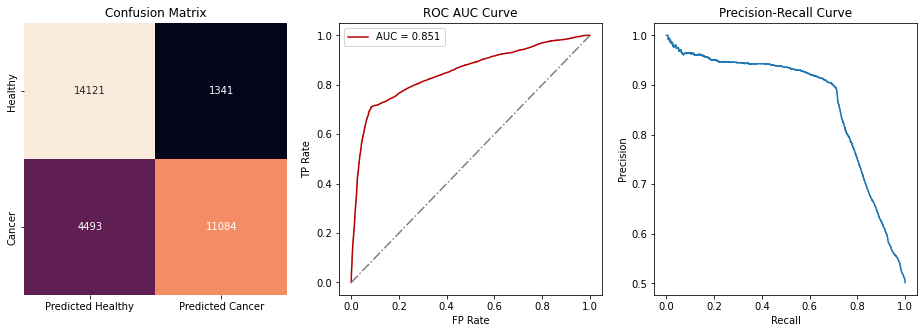

DecisionTreeClassifier
   precision    recall  f1-score  support
0   0.998382  0.997672  0.998027  15462.0
1   0.997691  0.998395  0.998043  15577.0
ROC AUC score: 0.9980333904730887
Accuracy Score: 0.9980347305003383


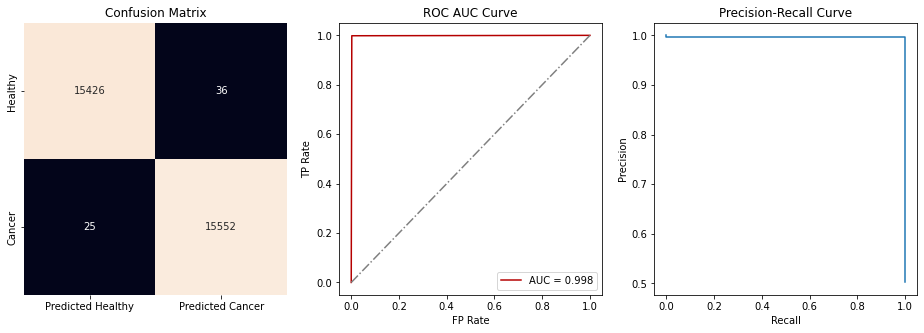

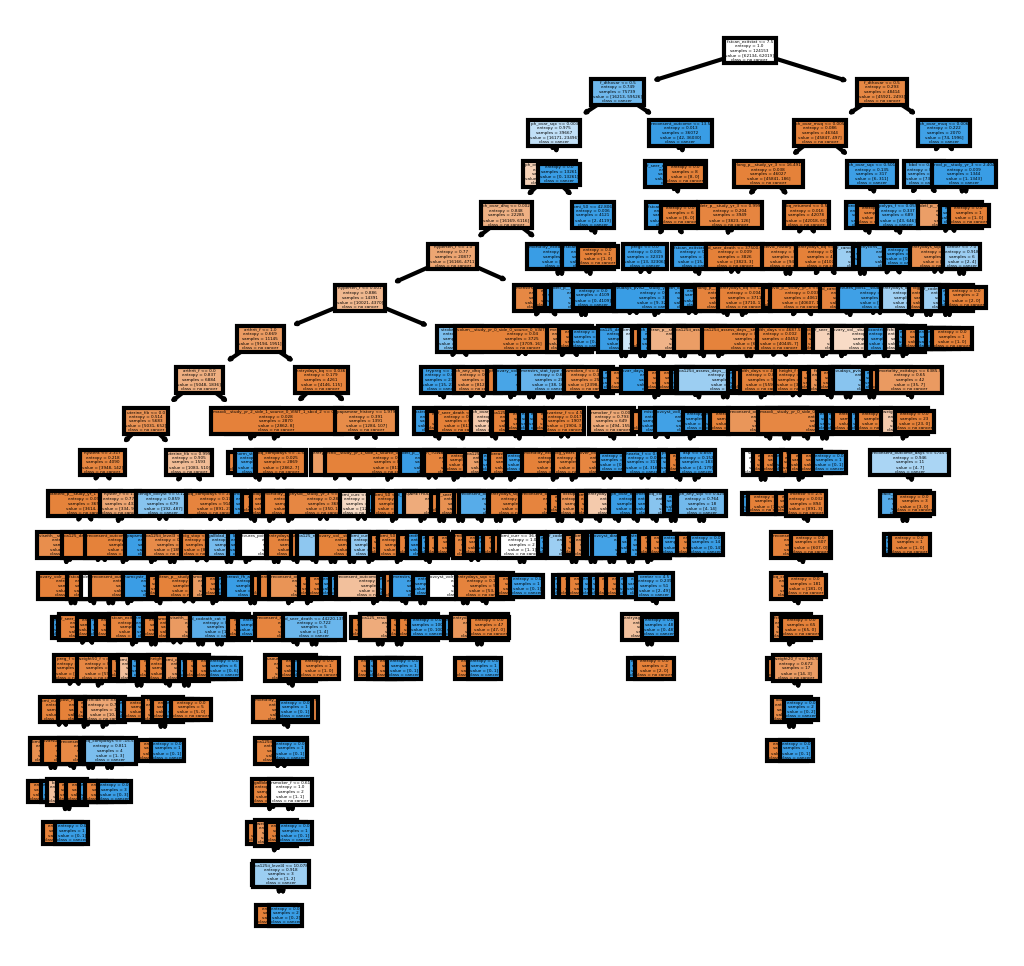

In [77]:
from sklearn.linear_model import LogisticRegression, LinearRegression
classifiers = {
    'LogisticRegression': LogisticRegression(C= 0.25, random_state= 0),
    # 'GaussianNB': GaussianNB(var_smoothing= 1e-09),
    'DecisionTreeClassifier': DecisionTreeClassifier(criterion= 'entropy', random_state= 0),
    # 'RandomForestClassifier': RandomForestClassifier(criterion= 'gini', n_estimators= 200, random_state= 0),
    # 'XGBClassifier': XGBClassifier(eval_metric= 'error', learning_rate= 0.1)
}
from sklearn import tree

auc_dict = {}
accuracy_dict = {}
for classifier_type, classifier in classifiers.items():
    print(classifier_type)
    auc, accuracy = run_classifier(classifier, X_train, X_test, y_train, y_test)
    if classifier_type == 'DecisionTreeClassifier':
        fn=X_train.columns
        cn=['no cancer', 'cancer']
        fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=300)
        tree.plot_tree(classifier,
            feature_names = fn, 
            class_names=cn,
            filled = True)
        plt.show()
    auc_dict[classifier_type] = auc
    accuracy_dict[classifier_type] = accuracy

In [78]:
# Determine on which features to use mean imputation and on which ones to replace with -1

 The initial dataset had 181 variables (Appendix 1). Variables were ranked by their F-score, which is the harmonic mean of precision and recall, with those with an F-score closest to 1.0 demonstrating high correlation with treatment success [10]. Experts in the treatment of BPH also selected variables for inclusion into the models irrespective of the F-Score, these variables, plus those with a high F-Score were selected for inclusion in initial model development.. The actual variables used by our models were a subset of these, and the number in any given fold and subgroup was dynamically determined by treating this as a hyper-parameter and tuning it as described below.